In [6]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/sms-spam-collection-dataset/spam.csv
/kaggle/input/sms-spam/sms-spam-collection-dataset


In [7]:
import pandas as pd

# Load the dataset from Kaggle input directory
df = pd.read_csv('/kaggle/input/sms-spam-collection-dataset/spam.csv', encoding='latin-1')

# Check the first few rows
df.head()


,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [8]:
# Keep only 'v1' and 'v2' columns
df = df[['v1', 'v2']]
df.columns = ['label', 'message']  # Rename for clarity

# Let's see a few examples
df.sample(5)


,label,message
4113,ham,Where are you ? What do you do ? How can you s...
1627,spam,You have been selected to stay in 1 of 250 top...
1476,ham,I'm watching lotr w my sis dis aft. So u wan 2...
2201,ham,A boy was late 2 home. His father: \POWER OF F...
2703,ham,Yup no more already... Thanx 4 printing n hand...


In [9]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
df['label_num'] = le.fit_transform(df['label'])

# ham → 0, spam → 1
df[['label', 'label_num']].value_counts()


label  label_num
ham    0            4825
spam   1             747
Name: count, dtype: int64

In [10]:
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

nltk.download('stopwords')

stemmer = PorterStemmer()
stop_words = set(stopwords.words('english'))

# Define a function to clean text
def clean_text(msg):
    msg = msg.lower()
    msg = ''.join([ch for ch in msg if ch not in string.punctuation])
    words = msg.split()
    words = [stemmer.stem(word) for word in words if word not in stop_words]
    return ' '.join(words)

# Apply cleaning
df['cleaned_message'] = df['message'].apply(clean_text)

# Preview
df[['message', 'cleaned_message']].head()


[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,message,cleaned_message
0,"Go until jurong point, crazy.. Available only ...",go jurong point crazi avail bugi n great world...
1,Ok lar... Joking wif u oni...,ok lar joke wif u oni
2,Free entry in 2 a wkly comp to win FA Cup fina...,free entri 2 wkli comp win fa cup final tkt 21...
3,U dun say so early hor... U c already then say...,u dun say earli hor u c alreadi say
4,"Nah I don't think he goes to usf, he lives aro...",nah dont think goe usf live around though


In [11]:
from sklearn.feature_extraction.text import CountVectorizer

# Initialize the vectorizer
vectorizer = CountVectorizer()

# Fit and transform the cleaned messages
X = vectorizer.fit_transform(df['cleaned_message'])

# Target labels
y = df['label_num']

# Shape of data (rows = messages, columns = unique words)
print(f"Feature matrix shape: {X.shape}")


Feature matrix shape: (5572, 8038)


In [12]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

print(f"Training size: {X_train.shape[0]}")
print(f"Testing size: {X_test.shape[0]}")


Training size: 4457
Testing size: 1115


In [13]:
from sklearn.naive_bayes import MultinomialNB

# Initialize and train the model
model = MultinomialNB()
model.fit(X_train, y_train)

# Predict on test set
y_pred = model.predict(X_test)


Accuracy: 0.9775784753363229

Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.99      0.99       965
           1       0.91      0.92      0.92       150

    accuracy                           0.98      1115
   macro avg       0.95      0.95      0.95      1115
weighted avg       0.98      0.98      0.98      1115



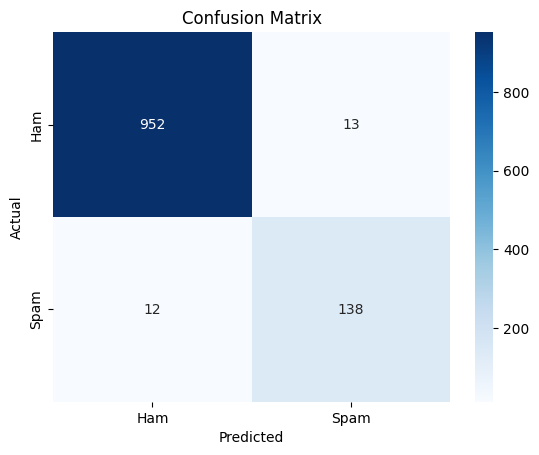

In [14]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Accuracy
print("Accuracy:", accuracy_score(y_test, y_pred))

# Classification report
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Ham', 'Spam'], yticklabels=['Ham', 'Spam'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


In [19]:
def predict_message(text):
    # Step 1: Clean the input message
    text_cleaned = clean_text(text)
    
    # Step 2: Vectorize it
    text_vector = vectorizer.transform([text_cleaned])
    
    # Step 3: Predict
    prediction = model.predict(text_vector)
    
    # Step 4: Decode the label (0 → ham, 1 → spam)
    return 'Spam' if prediction[0] == 1 else 'Ham'


In [20]:
# Example 1: Obvious spam
print(predict_message("Congratulations! You've won a free ticket. Call now!"))

# Example 2: Normal message
print(predict_message("Hey, are we still meeting at 6pm today?"))

# few more
print(predict_message("FREE entry into our £1000 prize draw, just click here!"))
print(predict_message("Can you please review the notes from class?"))


Spam
Ham
Spam
Ham
